In [1]:
from run import *

/home/yangxiaojie/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))


In [3]:
import pandas as pd
regions = pd.read_csv('/home/yangxiaojie/KDD2025/poi/FEA_hyoujun.csv')

In [4]:
def nan_to_empty_str(value):
    if pd.isna(value):
        return ''
    return str(value)


In [5]:
code2region = dict()
for i, row in regions.iterrows():
    code2region[str(row['標準地域コード']).zfill(5)] = row['都道府県'] + nan_to_empty_str(row['政令市･郡･支庁･振興局等']) + nan_to_empty_str(row['市区町村'])

In [6]:
def parse_args():
    parser = argparse.ArgumentParser(description="dose-response estimation via neural network")

    parser.add_argument('--reg_dim', type=int, default=64)
    parser.add_argument('--tim_dim', type=int, default=64)
    parser.add_argument('--hidden_dim', type=int, default=64)
    parser.add_argument('--init', type=float, default=0.01)
    parser.add_argument('--dynamic_type', type=str, default='power', choices=['power', 'mlp'])
    parser.add_argument('--dropout', type=float, default=0)
    parser.add_argument('--learning_rate', type=float, default=1e-3)
    parser.add_argument('--weight_decay', type=float, default=0)
    parser.add_argument('--input_dim', type=int, default=64)
    parser.add_argument('--treat_dim', type=int, default=4096)
    parser.add_argument('--treat_hidden', type=int, default=64)
    parser.add_argument('--reg_num', type=int, default=490)
    parser.add_argument('--tim_num', type=int, default=24)
    parser.add_argument('--device', type=str, default='cuda:0')
    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--num_epoch', type=int, default=300)
    parser.add_argument('--input_window', type=int, default=6)
    parser.add_argument('--interval', type=int, default=4)
    parser.add_argument('--output_window', type=int, default=1)
    parser.add_argument('--k', type=int, default=20)
    parser.add_argument('--training_rate', type=float, default=0.8)
    parser.add_argument('--validate_rate', type=float, default=0.1)
    parser.add_argument('--testing_rate', type=float, default=0.1)
    parser.add_argument('--causal', type=bool, default=True)
    parser.add_argument('--lr_step', type=int, default=3)
    parser.add_argument('--early_stop_lr', type=float, default=9e-6)
    parser.add_argument('--lr_decay', type=float, default=0.8)
    parser.add_argument('--cache', type=bool, default=False)
    parser.add_argument('--save', type=bool, default=False)
    parser.add_argument('--random', type=bool, default=True)
    parser.add_argument('--seeds', type=int, nargs='+', default=[76, 2015, 4974, 8767, 1893, 3447, 2799, 6838, 6147, 5490, 7033, 6884, 865, 2927, 9042, 3312, 781, 8141, 4374, 5073])  # 添加种子列表参数

    args = parser.parse_args([])
    
    with open('/home/yangxiaojie/KDD2025/osm_data/poi_distribution.pk', 'rb') as f:
        poi_distribution = pk.load(f)

    keys = set([poi_type for region in poi_distribution for poi_type in poi_distribution[region]])

    poi_region = np.zeros((len(poi_distribution), len(keys)))

    for i, region in enumerate(poi_distribution.keys()):
        for j, key in enumerate(keys):
            if key in poi_distribution[region]:
                poi_region[i, j] = poi_distribution[region][key]

    poi_data = (poi_region - poi_region.min()) / (poi_region.max() - poi_region.min())

    poi_data = torch.FloatTensor(poi_data)

    args.poi_num = len(keys)
    args.poi_data = poi_data
    args.pt_dim = 64
    
    return args


In [7]:
args = parse_args()

# 设置日志记录

expid = 'vis_test'


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', filename='/home/yangxiaojie/KDD2025/model/log/Training_{}.log'.format(expid), filemode='w')
logger = logging.getLogger()
args.expid = expid
logger.info('Argument settings:')
logger.info(args)
args.logger = logger
#pack_source(args)

In [8]:
dataset = CausalDatasetPreloader(args)
train_data, valid_data, test_data = dataset.data_split()

#train_dataset, valid_dataset, test_dataset = CausalDataset(args, train_data, mode='train'), CausalDataset(args, valid_data), CausalDataset(args, test_data)
test_dataset = CausalDataset(args, test_data)

# train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0)
# valid_dataloader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0)

scaler = dataset.scaler

Processing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8777/8777 [00:25<00:00, 348.20it/s]


In [25]:
import pickle as pk

with open('/home/yangxiaojie/KDD2025/selected_mesh.pk', 'rb') as f:
    selected_mesh = pk.load(f)

assert len(set(selected_mesh.values())) == args.reg_num

idx2code = dict(zip(list(range(args.reg_num)), sorted(set(selected_mesh.values()))))

In [27]:
device = 'cuda:0'
causal_model = torch.load('../models/model_6522_random_True.pth').to(device)
causal_model.eval()  # 设置模型为评估模式
causal_region_results = {}
general_region_results = {}
with torch.no_grad():  # 禁用梯度计算
    for batch in test_dataloader:
        batch = [_.to(device) for _ in batch]
        x, y, t, adj, treat, mask, indice = batch
        y = y.permute(0, 2, 1)
        #y = y.permute(0, 2, 1).reshape(y.shape[0] * y.shape[-1], -1)
        
        y_pre, w, z, treat = causal_model(x, t, treat, adj, mask)

        y_pre = y_pre.unsqueeze(-1).reshape(y.shape)

        for i in range(x.shape[0]):
            
            y_pred = scaler.inverse_transform(y_pre[i, :, :].permute(1, 0).cpu().squeeze()).detach().numpy()
            y_true = scaler.inverse_transform(y[i, :, :].permute(1, 0).cpu().squeeze()).detach().numpy()
            
            for j in range(args.reg_num):
                region_name = code2region[idx2code[j]]
                if region_name not in causal_region_results:
                    causal_region_results[region_name] = {}
                    causal_region_results[region_name]['pred'] = []
                    causal_region_results[region_name]['true'] = []
                    causal_region_results[region_name]['time'] = []

                    causal_region_results[region_name]['pred'].append(y_pred[j])
                    causal_region_results[region_name]['true'].append(y_true[j])
                    causal_region_results[region_name]['time'].append(indice[i, -args.output_window:].cpu().numpy().tolist())
                else:
                    causal_region_results[region_name]['pred'].append(y_pred[j])
                    causal_region_results[region_name]['true'].append(y_true[j])
                    causal_region_results[region_name]['time'].append(indice[i, -args.output_window:].cpu().numpy().tolist())

In [30]:
device = 'cuda:1'
general_model = torch.load('../models/model_3091_random_False.pth').to(device)
general_model.eval()
general_region_results = {}
with torch.no_grad():  # 禁用梯度计算
    for batch in test_dataloader:
        batch = [_.to(device) for _ in batch]
        x, y, t, adj, treat, mask, indice = batch
        y = y.permute(0, 2, 1)
        #y = y.permute(0, 2, 1).reshape(y.shape[0] * y.shape[-1], -1)
        
        y_pre, w, z, treat = general_model(x, t, treat, adj, mask)

        y_pre = y_pre.unsqueeze(-1).reshape(y.shape)

        for i in range(x.shape[0]):
            
            y_pred = scaler.inverse_transform(y_pre[i, :, :].permute(1, 0).cpu().squeeze()).detach().numpy()
            y_true = scaler.inverse_transform(y[i, :, :].permute(1, 0).cpu().squeeze()).detach().numpy()
            
            for j in range(args.reg_num):
                region_name = code2region[idx2code[j]]
                if region_name not in general_region_results:
                    general_region_results[region_name] = {}
                    general_region_results[region_name]['pred'] = []
                    general_region_results[region_name]['true'] = []
                    general_region_results[region_name]['time'] = []

                    general_region_results[region_name]['pred'].append(y_pred[j])
                    general_region_results[region_name]['true'].append(y_true[j])
                    general_region_results[region_name]['time'].append(indice[i, -args.output_window:].cpu().numpy().tolist())
                else:
                    general_region_results[region_name]['pred'].append(y_pred[j])
                    general_region_results[region_name]['true'].append(y_true[j])
                    general_region_results[region_name]['time'].append(indice[i, -args.output_window:].cpu().numpy().tolist())

In [31]:
from datetime import datetime, timedelta

# 假设起始时间戳为 '2024-06-14 08:00:00'
start_timestamp = '2023-04-01 00:00:00'

# 将起始时间戳转换为 datetime 对象
start_time = datetime.strptime(start_timestamp, '%Y-%m-%d %H:%M:%S')

In [32]:
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

In [34]:
causal_region_results.keys()

dict_keys(['北海道札幌市中央区', '北海道札幌市北区', '北海道札幌市東区', '北海道札幌市白石区', '北海道札幌市豊平区', '北海道札幌市南区', '北海道札幌市西区', '北海道札幌市厚別区', '北海道札幌市手稲区', '北海道札幌市清田区', '北海道函館市', '北海道小樽市', '北海道旭川市', '北海道室蘭市', '北海道釧路市', '北海道帯広市', '北海道北見市', '北海道岩見沢市', '北海道苫小牧市', '北海道江別市', '北海道千歳市', '北海道北広島市', '青森県青森市', '青森県弘前市', '青森県八戸市', '岩手県盛岡市', '岩手県花巻市', '岩手県北上市', '岩手県一関市', '岩手県奥州市', '宮城県仙台市青葉区', '宮城県仙台市宮城野区', '宮城県仙台市若林区', '宮城県仙台市太白区', '宮城県仙台市泉区', '宮城県石巻市', '宮城県名取市', '宮城県多賀城市', '宮城県大崎市', '秋田県秋田市', '山形県山形市', '山形県鶴岡市', '山形県酒田市', '山形県天童市', '福島県福島市', '福島県会津若松市', '福島県郡山市', '福島県いわき市', '茨城県水戸市', '茨城県日立市', '茨城県土浦市', '茨城県古河市', '茨城県取手市', '茨城県つくば市', '茨城県ひたちなか市', '茨城県筑西市', '茨城県つくばみらい市', '栃木県宇都宮市', '栃木県足利市', '栃木県栃木市', '栃木県佐野市', '栃木県鹿沼市', '栃木県小山市', '栃木県那須塩原市', '群馬県前橋市', '群馬県高崎市', '群馬県桐生市', '群馬県伊勢崎市', '群馬県太田市', '群馬県館林市', '群馬県渋川市', '群馬県藤岡市', '群馬県安中市', '群馬県みどり市', '埼玉県さいたま市北区', '埼玉県さいたま市大宮区', '埼玉県さいたま市見沼区', '埼玉県さいたま市中央区', '埼玉県さいたま市桜区', '埼玉県さいたま市浦和区', '埼玉県さいたま市南区', '埼玉県さいたま市緑区', '埼玉県さいたま市岩槻区', '埼玉県川越市', '埼玉県熊谷市', '埼玉県川口市', '埼玉県行田市', '埼玉県所沢市', '埼玉県加須市

In [131]:
def validation_loss(y_preds, y_trues):
    """
    计算预测模型的各种误差指标，包括 MSE, RMSE, MAE, 和 MAPE。
    
    参数:
    y_preds (list or np.array): 预测值
    y_trues (list or np.array): 真实值
    
    返回:
    dict: 包含 MSE, RMSE, MAE, 和 MAPE 的字典
    """
    y_preds = np.array(y_preds)
    y_trues = np.array(y_trues)
    
    mse = np.mean((y_preds - y_trues) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_preds - y_trues))
    mape = np.mean(np.abs((y_trues - y_preds) / y_trues)) * 100  # 乘以100表示为百分比

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

In [133]:
for name in causal_region_results.keys():
    print(name)
    print(validation_loss(causal_region_results[name]['pred'], causal_region_results[name]['true']))
    print(validation_loss(general_region_results[name]['pred'], general_region_results[name]['true']))
    print()

北海道札幌市中央区
{'MSE': 4007.7263, 'RMSE': 63.306606, 'MAE': 37.515255, 'MAPE': 1.567811705172062}
{'MSE': 2978.2542, 'RMSE': 54.573383, 'MAE': 37.60088, 'MAPE': 1.592768169939518}

北海道札幌市北区
{'MSE': 549.81836, 'RMSE': 23.448206, 'MAE': 16.569979, 'MAPE': 0.8155828341841698}
{'MSE': 461.4922, 'RMSE': 21.482368, 'MAE': 15.210924, 'MAPE': 0.7481398060917854}

北海道札幌市東区
{'MSE': 1102.6823, 'RMSE': 33.20666, 'MAE': 22.240602, 'MAPE': 0.7064690347760916}
{'MSE': 959.38995, 'RMSE': 30.97402, 'MAE': 20.434282, 'MAPE': 0.6492530461400747}

北海道札幌市白石区
{'MSE': 530.6377, 'RMSE': 23.035574, 'MAE': 16.66077, 'MAPE': 0.9381269104778767}
{'MSE': 565.9542, 'RMSE': 23.789793, 'MAE': 17.27687, 'MAPE': 0.9718886576592922}

北海道札幌市豊平区
{'MSE': 2024.0586, 'RMSE': 44.98954, 'MAE': 31.094612, 'MAPE': 0.9320179000496864}
{'MSE': 1810.4926, 'RMSE': 42.549885, 'MAE': 29.801748, 'MAPE': 0.9003065526485443}

北海道札幌市南区
{'MSE': 305.4654, 'RMSE': 17.477568, 'MAE': 12.499441, 'MAPE': 0.841781497001648}
{'MSE': 276.22668, 'RMSE': 

{'MSE': 382.69318, 'RMSE': 19.562546, 'MAE': 14.411054, 'MAPE': 1.0788346640765667}
{'MSE': 331.88852, 'RMSE': 18.217808, 'MAE': 13.377914, 'MAPE': 1.0011757723987103}

愛知県東海市
{'MSE': 403.8032, 'RMSE': 20.094854, 'MAE': 14.496774, 'MAPE': 1.3096156530082226}
{'MSE': 387.8924, 'RMSE': 19.694984, 'MAE': 14.430093, 'MAPE': 1.3050164096057415}

愛知県大府市
{'MSE': 367.21902, 'RMSE': 19.16296, 'MAE': 13.985433, 'MAPE': 1.3051282614469528}
{'MSE': 314.14856, 'RMSE': 17.724237, 'MAE': 13.152484, 'MAPE': 1.2294184416532516}

愛知県知立市
{'MSE': 350.17874, 'RMSE': 18.713064, 'MAE': 13.864729, 'MAPE': 1.1398532427847385}
{'MSE': 344.7748, 'RMSE': 18.568113, 'MAE': 13.730334, 'MAPE': 1.1298002675175667}

愛知県尾張旭市
{'MSE': 307.1624, 'RMSE': 17.526049, 'MAE': 12.702083, 'MAPE': 1.0634846054017544}
{'MSE': 290.63397, 'RMSE': 17.04799, 'MAE': 12.116724, 'MAPE': 1.0113629512488842}

愛知県豊明市
{'MSE': 394.16846, 'RMSE': 19.853676, 'MAE': 14.058216, 'MAPE': 1.225889939814806}
{'MSE': 369.86307, 'RMSE': 19.231825, 'MAE

In [129]:
causal_region_results[name]['pred']

[801.62933,
 824.2475,
 840.5982,
 828.95074,
 852.6542,
 881.09827,
 864.6413,
 837.34753,
 840.92285,
 839.1078,
 805.70013,
 772.6932,
 777.48895,
 775.1564,
 784.5473,
 794.75793,
 796.188,
 773.56165,
 774.04315,
 772.4343,
 775.1757,
 777.096,
 789.9199,
 798.5579,
 778.12463,
 786.8961,
 804.6828,
 823.4185,
 817.90826,
 818.548,
 815.7361,
 832.94415,
 822.8329,
 793.7612,
 774.0903,
 791.71173,
 784.96387,
 725.60223,
 741.9522,
 751.89124,
 759.8396,
 760.6823,
 752.80646,
 752.14154,
 754.573,
 755.41,
 754.4979,
 784.27155,
 786.6315,
 781.08295,
 798.18274,
 789.32214,
 798.4802,
 789.6508,
 787.8422,
 785.33026,
 788.21515,
 760.8531,
 782.77,
 800.8555,
 768.9559,
 742.24835,
 773.43536,
 759.90594,
 769.804,
 789.09235,
 785.81244,
 787.38794,
 786.7343,
 790.61945,
 793.8515,
 813.8157,
 823.40924,
 807.9412,
 809.22144,
 797.93634,
 811.813,
 801.2803,
 796.5965,
 809.28784,
 801.8375,
 819.1512,
 788.02277,
 788.39685,
 760.1258,
 769.6551,
 769.94617,
 793.36,
 786.

In [134]:
name = '大阪府四條畷市'

value = list(causal_region_results[name].values())
causal_pred = value[0]
general_pred = list(general_region_results[name].values())[0]
true = value[1]
hours = value[2]
stamps = []
causal_preds = []
general_preds = []
trues = []
for i in range(len(hours)):
    stamp = start_time + timedelta(days=hours[i][0]//24, hours=hours[i][0]%24)
    stamps.append(stamp.strftime('%Y-%m-%d %H:%M:%S'))
    causal_preds.append(causal_pred[i])
    general_preds.append(general_pred[i])
    trues.append(true[i])

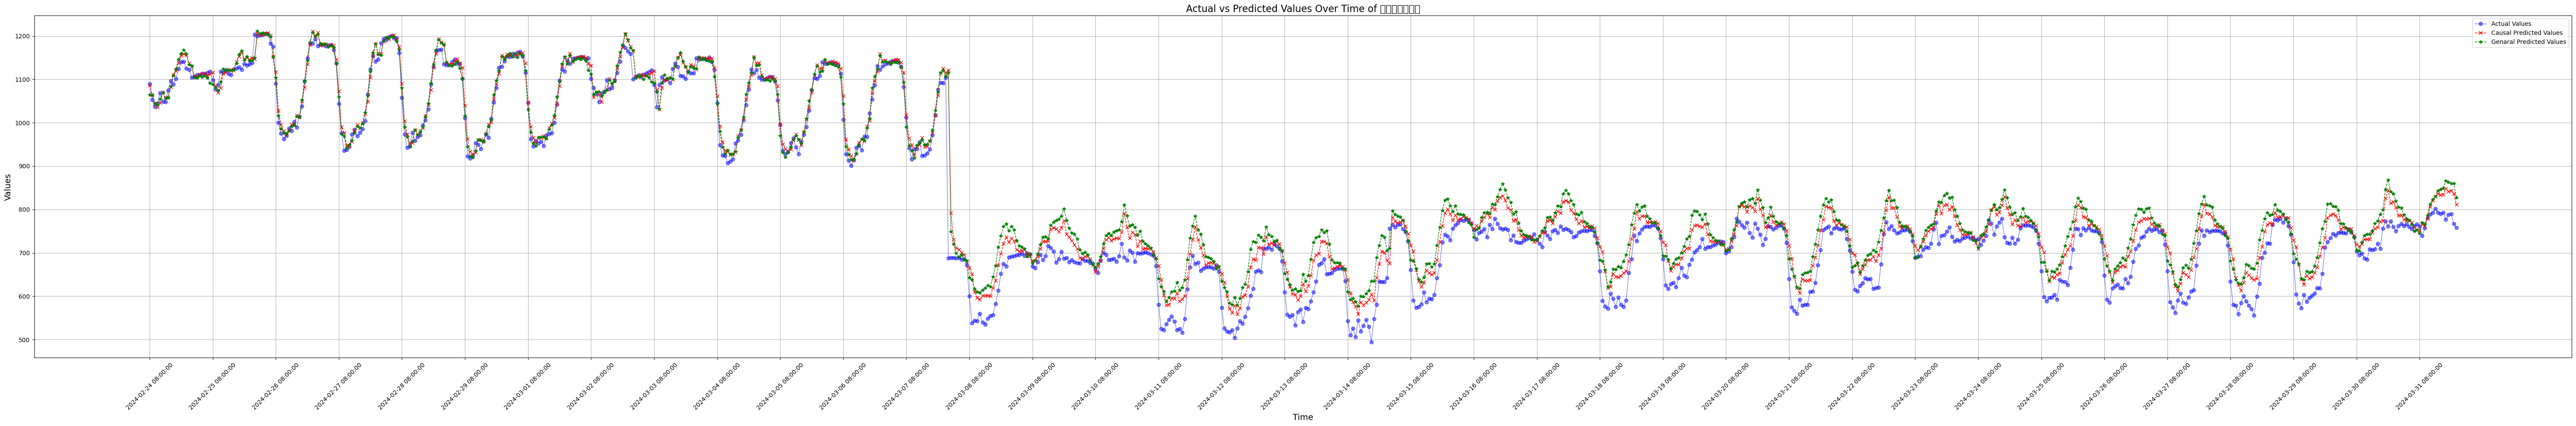

大阪府四條畷市


In [135]:
# 创建图表
plt.figure(figsize=(60, 10))

# 绘制真实值的折线图
plt.plot(stamps, trues, label='Actual Values', color='blue', marker='o', linestyle='-', linewidth = 1, alpha = 0.5)

# 绘制预测值的折线图
plt.plot(stamps, causal_preds, label='Causal Predicted Values', color='red', marker='x', linestyle='--', linewidth = 1, alpha = 1)

# 绘制预测值的折线图
plt.plot(stamps, general_preds, label='Genaral Predicted Values', color='green', marker='*', linestyle='--', linewidth = 1, alpha = 1)

# 设置 x 轴的刻度标签，每隔24个显示一个时间戳
xticks_indices = list(range(0, len(stamps), 24))
xticks_labels = [stamps[i] for i in xticks_indices]
plt.xticks(ticks=xticks_indices, labels=xticks_labels, rotation=45)

# 添加图例
plt.legend()

# 添加标题和标签
plt.title('Actual vs Predicted Values Over Time of {}'.format(name), fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Values', fontsize=14)

# 显示网格线
plt.grid(True)

# 调整布局，避免标签重叠
plt.tight_layout()

# 显示图表
plt.show()
print(name)

In [68]:
news = pd.read_csv('/home/yangxiaojie/KDD2025/samples・説明書/news_with_codes.csv')

In [70]:
news = news[['DateAndTime', 'InBClass', 'InJpnAreaName', 'InHeadLine', 'Content']]

news['DateAndTime'] = pd.to_datetime(news['DateAndTime'])

start_date = '2024-03-01'
end_date = '2024-03-31'

# 使用布尔索引筛选日期范围内的新闻
news = news[(news['DateAndTime'] >= start_date) & (news['DateAndTime'] <= end_date)]

In [81]:
news[news['InJpnAreaName'].str.contains('石川県')]

DateAndTime                       InBClass  \
63564  2024-03-10 17:38:48                  教育, 政治, 災害・事故   
81844  2024-03-14 19:15:48        教育, 環境, 文化, 災害・事故, スポーツ   
81845  2024-03-28 14:33:44        教育, 環境, 文化, 災害・事故, スポーツ   
93001  2024-03-13 16:35:06           経済・産業, 社会, 生活・余暇, 政治   
95396  2024-03-03 14:46:48    戦争・紛争, 文化, 災害・事故, 犯罪・司法, 社会   
...                    ...                            ...   
126220 2024-03-30 16:43:29                          災害・事故   
126249 2024-03-30 18:35:17           災害・事故, 生活・余暇, 文化, 気象   
126261 2024-03-30 18:56:47                    スポーツ, 災害・事故   
126287 2024-03-30 20:23:07  スポーツ, 災害・事故, 生活・余暇, 経済・産業, 健康   
126288 2024-03-30 20:23:12  スポーツ, 災害・事故, 生活・余暇, 経済・産業, 健康   

                                            InJpnAreaName  \
63564   福島県, 岩手県, 岩手県盛岡市, 宮城県, 宮城県仙台市, 福島県福島市, 石川県, 石川...   
81844                               千葉県流山市, 千葉県, 石川県, 長野県   
81845                               千葉県流山市, 千葉県, 石川県, 長野県   
93001       福井県, 石川県, 富山県, 富山県富山市, 石川県金沢市, 福井県福井市, 福井県敦賀市   
95396               東京都, 茨城県鹿嶋市, 東京都大田区, 石川県, 石川県金沢市, 茨城県   
...                                                   ...   
126220                                        石川県, 石川県輪島市   
126249          石川県, 神奈川県横浜市, 石川県金沢市, 福井県, 福井県福井市, 石川県輪島市   
126261                                        石川県小松市, 石川県   
126287                                                石川県   
126288                                                石川県   

                       InHeadLine  \
63564     貸し付けでなく給付型創設 関西大の山崎栄一教授   
81844   ぬくもり感じる森の学び舎 教育現場ならではの工夫も   
81845   ぬくもり感じる森の学び舎 教育現場ならではの工夫も   
93001    人口減の中、利用促進模索 敦賀延伸後の並行在来線   
95396    空襲孤児の半生、詩に詠み 金沢で展示、復興支援も   
...                           ...   
126220       山下元監督、奮闘見守る 甲子園から（３）   
126249    坐禅堂修復へクラファン 石川・輪島の総持寺祖院   
126261      川岸、被災地に元気を 女子ゴルフから（１）   
126287             差し替え　高校野球・星稜囲み   
126288   星稜、一歩及ばず力尽きる 被災も健闘、思い新たに   

                                                  Content  
63564   関西大の山崎栄一やまさき・えいいち教授（災害法制）の話滞納額がこれほど膨らんでいる状況で今後...  
81844   木の香りやぬくもりを感じながら子どもたちが学ぶ学校が千葉県流山ながれやま市にあります。市立お...  
81845   木の香りやぬくもりを感じながら子どもたちが学ぶ学校が千葉県流山ながれやま市にあります。市立お...  
93001   １６日の北陸新幹線金沢―敦賀（福井県敦賀市）間の延伸開業に伴い、石川、福井両県の並行在来線約...  
95396   あの夜奪われた多くの魂を胸に―。東京大空襲で孤児となり、各地の空襲被害者への補償を求め活動す...  
...                                                   ...  
126220  〇…星稜の山下智茂元監督が、スタンドで奮闘を見守った。長男が指揮を執るチームは決勝進出を逃し...  
126249  石川県輪島市門前町の曹洞宗・総持寺祖院が、能登半島地震で大きな被害を受けた「坐禅堂」の修復資...  
126261  〇…通算２勝の川岸が安定したプレーで６８と伸ばし、２位につけた。「前半の風だとアンダーパーで...  
126287  共Ａ３Ｋ０１２３高野５１８Ｓ「星稜、一歩及ばず力尽きる」の１０行目「言葉を振り絞った。」を「...  
126288  最後まで力を尽くしたが、決勝の舞台に一歩及ばなかった。昨秋の明治神宮大会覇者で優勝候補として...  

[1220 rows x 5 columns]

In [92]:
for i, row in news[news['Content'].str.contains('地震')].iterrows():
    print(row['DateAndTime'])
    print(row['InJpnAreaName'])
    print(row['InHeadLine'])
    print(row['Content'])
    print()

2024-03-01 18:01:37
新潟県, 新潟県新潟市, 新潟県十日町市, 大阪府大阪市, 東京都, 大阪府
これからの棚田保全 ＮＰＯ法人「地域おこし」　多田朋孔
去る８月に東京大学農学部にて開催された棚田学会大会シンポジウムにおいて、私が代表理事を務める新潟県十日町市のＮＰＯ法人地域おこしが棚田学会賞を受賞した。当法人は２００４年の新潟県中越地震で被災したことをきっかけに、前代表理事の山本浩史やまもと・ひろしが復興ボランティアの受け入れ団体として活動を開始し、２０年弱にわたって取り組みを継続してきた。今では移住者を受け入れ、棚田の耕作も移住者が大半を引き継ぎ、米の直販によって経済的にも安定しつつあるというところまできた。このような取り組みが評価され、棚田学会賞の受賞につながったのだと思う。棚田は自然のダムの機能を有しており、これによって大雨が一気に降った時の洪水の被害を抑えられるわけだが、近年毎年のように全国のどこかで洪水の被害が甚大であることが報道されている。そういう意味でも棚田の保全というのは街中に住む人にとっても重要なテーマであると言える。しかしながら、多くの棚田地域では、耕作している中心的な世代は６０～８０代の高齢者である。若い人が関係人口として農作業の手伝いに通ってくるケースもあるが、若い人が中心になっているというところはまだまだごく少数である。これから将来に向けて本当に全国各地での棚田保全を実現させるためには、棚田での耕作を高齢者から若い人に引き継いでいける仕組みづくりが必要だ。そのためには、棚田での稲作が経済的に成り立つ必要がある。棚田が米を作る以外の価値を持っているので保全する必要があるというのであれば、財政を投入する価値があると思う。例えば、欧州連合（ＥＵ）に加盟する１５カ国では農業関係の助成金の６４％が環境保全や不利な耕作条件を支援するためのものだ。日本でもこれに倣い、棚田の保全は公共事業でもあるという位置付けをしてみるという考え方も必要なのではなかろうか？そして棚田保全という仕事が、きついけどやりがいがあってある程度安定した収入が得られるようになれば、若い後継者も参入しやすくなると思う。政府は増税するのであれば、必要なところにぜひとも税金を投資していただきたいと切に願う。××ただ・ともよし１９７８年、大阪市生まれ。京大卒。ＮＰＯ法人

2024-03-26 08:11:06
鹿児島県, 鹿児島県鹿児島市, 鹿児島県霧島市
鹿児島・霧島で震度１
２６日午前８時１分ごろ、鹿児島県霧島市で震度１の地震があった。気象庁によると、震源地は薩摩地方で、震源の深さはごく浅い。地震の規模はマグニチュード（Ｍ）２・８と推定される。

2024-03-26 15:39:00
石川県, 石川県金沢市
番外５２　両陛下、４月中旬に能登被災地再訪で調整
天皇、皇后両陛下が能登半島地震の被災者を見舞うため、４月中旬に石川県を再び訪問される方向で宮内庁が調整していることが２６日、関係者への取材で分かった。両陛下は今月２２日に初めて被災地入りしていた。

2024-03-26 15:48:38
石川県, 石川県金沢市, 石川県輪島市, 石川県珠洲市
両陛下、再び能登被災地へ 宮内庁、４月中旬で調整
天皇、皇后両陛下が能登半島地震の被災者を見舞うため、４月中旬に石川県を日帰りで再び訪問される方向で宮内庁が調整していることが２６日、同庁関係者への取材で分かった。両陛下は今月２２日に石川県の輪島市と珠洲市を日帰りで訪問した。能登半島地震で初の被災地入りだった。火災で大半が焼失した輪島市の「輪島朝市」や津波被害を受けた珠洲市の飯田港で黙とうしたほか、両市の避難所に足を運び、被災者を励ました。宮内庁関係者によると、今回は輪島、珠洲両市以外で大きな被害が出た能登地方の自治体を訪問先として検討している。現地の道路状況を考慮し、移動はヘリコプターを利用する見通しという。

2024-03-26 15:50:09
石川県, 石川県金沢市, 石川県輪島市
安否不明の方々
能登半島地震で安否が不明になっているとして石川県が２６日に公表したのは次の方々。（２６日午後２時現在。年齢は１月１日時点）【輪島市】垣地英次かきち・ひでつぐさん（５６）、北戸周一きたど・しゅういちさん（７８）、伏木野茂雄ふしきの・しげおさん（６８）問い合わせは石川県危機対策課、電話０７６（２２５）１３０６。

2024-03-26 15:57:10
富山県, 石川県, 福井県, 新潟県, 新潟県新潟市, 富山県富山市, 石川県金沢市, 福井県福井市, 石川県輪島市
番外５４　能登半島地震の死者、２４４人に
石川県は２６日、能登半島地震で確認された死者が新たに輪島市で３人増え、同日午

In [110]:
for i, row in news[(news['InBClass'].str.contains('災害・事故')) & (~news['InBClass'].str.contains('政治')) & (~news['InBClass'].str.contains('スポーツ'))].iterrows():
    print(row['DateAndTime'])
    print(row['InJpnAreaName'])
    print(row['InHeadLine'])
    print(row['Content'])
    print()

2024-03-29 10:50:24
東京都, 東京都新宿区
東京女子医大
東京女子医大東京都新宿区にある私立大。医師吉岡弥生よしおか・やよいが１９００年に創立した東京女医学校を母体とする。大学は、国内外で唯一の女性のみに医学教育を行う機関としている。臓器移植で有数の実績を持ち、高度医療を提供する特定機能病院として国に承認されていたが、２歳男児が死亡した医療事故により２０１５年に取り消され現在も再承認に至っていない。

2024-03-29 11:34:00
東京都, 東京都新宿区
差し替え　東京女子医大・ズーム
共Ａ３Ｔ０３２５社会０３０Ｓ「東京女子医大」の８～１２行目「臓器移植で有数の実績を持ち、高度医療を提供する特定機能病院として国に承認されていたが」を「大学病院は臓器移植で有数の実績を持ち、高度医療を提供する特定機能病院として国に承認されていたが」と差し替え。

2024-03-29 11:34:08
東京都, 東京都新宿区
東京女子医大
東京女子医大東京都新宿区にある私立大。医師吉岡弥生よしおか・やよいが１９００年に創立した東京女医学校を母体とする。大学は、国内外で唯一の女性のみに医学教育を行う機関としている。臓器移植で有数の実績を持ち、高度医療を提供する特定機能病院として国に承認されていたが、大学病院は臓器移植で有数の実績を持ち、高度医療を提供する特定機能病院として国に承認されていたが、２歳男児が死亡した医療事故により２０１５年に取り消され現在も再承認に至っていない。

2024-03-08 12:06:58
京都府八幡市, 京都府, 京都府久世郡久御山町
「絵になる」たたずまい 時代劇のロケ地にも 京都府八幡市の「流れ橋」
「必殺仕事人」「水戸黄門」に「暴れん坊将軍」。時代劇のロケ地として知られる京都府南部の八幡市と久御山町を結ぶ「流れ橋」。中村主水なかむら・もんどや水戸黄門らヒーローたちを引き立て、物語にリアリティーを与えてきた「絵になる」橋を訪ねた。石清水八幡宮駅から約６㌔離れた目的地へと向かうため、まずは駅前で自転車を借りる。地元で「はちまんさん」と親しまれる国宝の石清水八幡宮はすぐ近くだが、この日はスルーだ。草を刈る音や鳥のさえずりを聞きながら、木津川沿いのサイクリングロードをトンボと並走する。のどかだ。ロードバイクに追い抜かれつつ上流に向か

2024-03-15 11:04:22
福島県, 福島県福島市
差し替え　震度５弱
共Ａ３Ｔ０１１５社会０１６Ｓ「福島で震度５弱」の８行目「福島地方気象台によると、」～１７行目「手動停止した。」を次と差し替え。気象庁によると、津波は観測されなかった。県によると、けが人はおらず住宅被害もなかった。東京電力は震度５弱以上の地震があった場合の手順にのっとり福島第１原発の処理水海洋放出を手動停止した。東電によると、処理水放出は昨年８月に始まり、今年２月２８日から４回目を実施中だった。地震後のパトロールで設備に異常がないと確認。１５日にも放出を再開する。放出途中での停止は初めて。

2024-03-15 11:04:27
福島県, 福島県福島市
福島で震度５弱 原発処理水の放出停止
１５日午前０時１４分ごろ、福島県で震度５弱の地震があった。気象庁によると、震源地は福島県沖で、震源の深さは約５０㌔。地震の規模はマグニチュード（Ｍ）５・８と推定される。福島地方気象台によると、津波はなかったとみられる。福島県によると、午前７時時点でけが人の情報は入っていない。東京電力によると、事前の手順にのっとり福島第１原発の処理水海洋放出を手動停止した。原子力規制委員会や電力各社によると、東電福島第１、第２原発（福島県）、東北電力女川原発（宮城県）、日本原子力発電東海第２原発（茨城県）に異常は確認されていない。１５日午前０時１４分ごろ、福島県で震度５弱の地震があった。気象庁によると、震源地は福島県沖で、震源の深さは約５０㌔。地震の規模はマグニチュード（Ｍ）５・８と推定される。気象庁によると、津波は観測されなかった。県によると、けが人はおらず住宅被害もなかった。東京電力は震度５弱以上の地震があった場合の手順にのっとり福島第１原発の処理水海洋放出を手動停止した。東電によると、処理水放出は昨年８月に始まり、今年２月２８日から４回目を実施中だった。地震後のパトロールで設備に異常がないと確認。１５日にも放出を再開する。放出途中での停止は初めて。原子力規制委員会や電力各社によると、東電福島第１、第２原発（福島県）、東北電力女川原発（宮城県）、日本原子力発電東海第２原発（茨城県）に異常は確認されていない。政府は１５日未明、首相官邸に情報連絡室を設置。総務省消防庁の全国瞬時警報システム（Ｊアラート）は、予想最大

In [115]:
for i, row in news[news['Content'].str.contains('大雨')].iterrows():
    print(row['DateAndTime'])
    print(row['InJpnAreaName'])
    print(row['InHeadLine'])
    print(row['Content'])
    print()

2024-03-05 13:38:05
東京都
人生は価値観合う人探す旅 ポップスピアニスト ハラミちゃん
お肉のハラミが大好きで、絶対音感があるハラミちゃんです。全国で街にあるストリートピアノを即興演奏してユーチューブに上げています。４歳からピアノ教室に通い、将来は音楽大学に入ってピアニストになるつもりでした。小１で受験用テキストを渡されて音大入試を意識し、小中高校時代、家では寝る時と食べる時以外は練習づけでした。父は「芸は身を助ける」という教育方針で、グランドピアノを買ってくれました。私は人を笑わせるのが好きで、小学校時代は変な顔をして演奏したり、「倒れそうなアンパンマンを弾くね」と曲を暗くアレンジして友達を楽しませたりしました。▽笑った人が勝ち中学校の３年間はつらかったです。ある女の子に「ほかの子と話さないで」と束縛され、荷物を持たされ、チクチク言われるような攻撃を受けました。保健室やトイレにこもり、家では毎日、「大雨警報で休校になれ」と祈りました。でも、高校で前の席に座った明るい子に助けられ、今も親友です。中高生時代は軽音楽部でバンド活動をしていました。ピアノ以外の楽器も弾いてみたかったんです。有名な先生に教わった高２の時、第１志望の音大を伝えると「それは無理」と却下されました。ピアニストの夢を絶たれた私は「音楽の先生になりたい」と言いました。第２志望の音大に入り、教育実習にも行ったけど、進路に迷いました。そんな時、他大学と合同の軽音楽サークルで、優秀な仲間が音楽を趣味と割り切って就職するのを見て価値観が変わりました。パソコンを触ったこともなかったけど、ＩＴ企業に就職しました。だけど、そこでも、ピアノの練習を必死にやったのと同じで、がんばりすぎて燃え尽き、会社に行けなくなりました。休職中、会社の先輩に誘われて、東京都庁のストリートピアノで演奏し、動画を上げたのがきっかけでブレークしました。動画の私は笑顔で、先輩の「１回でも多く笑った人が勝ち」という言葉を思い出してハラミちゃんになる決心をしました。▽経験は冷凍保存音楽は数学などと違い、正解がない教科。同じ曲でも感じ方は十人十色です。どんな曲も好きな人がいると授業で体感してほしい。感性を養い、人生を豊かにするのが音楽の良さです。芸術を通して感性が育つと、絵を見ても「よく分からない」で終わらない。読書や人との会話

In [141]:
for i, row in news[news['Content'].str.contains('祭り')].iterrows():
    print(row['DateAndTime'])
    print(row['InJpnAreaName'])
    print(row['InHeadLine'])
    print(row['Content'])
    print()

2024-03-07 18:17:01
高知県, 埼玉県, 埼玉県さいたま市, 高知県高知市, 高知県高岡郡越知町
田舎に憧れ脱サラ移住 住民と製作、サンショウ枕
すっきりとしたサンショウの香りが部屋いっぱいに広がる。「この布は薄いから内側に使うのが良さそうやねえ」。高知県越知町の地域おこし協力隊員清水香しみず・かおりさん（５１）と、３人の地元女性が、和気あいあいと民家でサンショウの種を使った枕を作っていた。清水さんは、高知県主催の移住相談会で越知町を知った。田舎暮らしへの憧れもあり、脱サラして埼玉から２０２１年に着任。祭りの準備や草刈り、何でも手伝い、町民に溶け込んできた。地元で有名なラーメンを土産品にしようと商品化に挑んだこともあったが、コストや再現の難しさから断念。サンショウ枕のアイデアは、清水さんが「お母さん」と呼ぶ女性たちに教えてもらった。県はサンショウの生産量が全国２位。町の農業法人は年間６０㌧の種を廃棄している。「無料の物から価値を生み出したい」と製品化した。枕はふるさと納税の返礼品にもなった。町役場の担当者は「住民と一緒に地域の物を使い活動してくれ、助かる」と歓迎している。清水さんは「新しいことをするのは楽しい。山々の風景にも癒やされる」と、４月の任期終了後も定住すると決めている。枕やサンショウ肉まんの販売、飲食店のアルバイトなどで生計を立てる計画だ。「お母さんたちに出会っていなければ、町に残っていなかったかも。不安は大きいが、まずはやってみる」と意気込む。

2024-03-28 15:22:55
新潟県魚沼市, 新潟県南魚沼市, 新潟県
復活した仕事着サンパク 斜め方向に伸びる布 横田尚美
洋服が仕事着として定着する以前は、各地にさまざまな和式の仕事着が存在した。ボトムス（下衣）としては女性用のモンペが知られるが、男性用のパッチや股引ももひきは、祭りの衣装としては今もはかれている。筆者はかつて１０年ほど、新潟県南魚沼市六日町の暮らしについて調査をしていた。ここでは、サンパクという下衣があり、男女ともに着用する。地元の人によれば、「山袴」と書くという。これは、股に大きな「まち」が付いている。まちは、基本のパーツの布では足りないところに付け足す布のことを言う。サンパクでは、大きなひし形の布が股に付けられる。布には、方向がある。織物は、経糸たていとを張

In [140]:
for i, row in news[news['Content'].str.contains('四條畷市')].iterrows():
    print(row['DateAndTime'])
    print(row['InJpnAreaName'])
    print(row['InHeadLine'])
    print(row['Content'])
    print()